In [228]:
import pandas as pd
import numpy as np
import pyarrow as pw
from google.cloud import bigquery
import seaborn as sns

In [2]:
client = bigquery.Client.from_service_account_json(
    'Replace-with-value')

In [229]:
sql = '''
    WITH
  events AS (
  SELECT
    date,
    visitId,
    fullVisitorId
  FROM
    `Replace.ga_sessions_*`,
    UNNEST (hits)
  WHERE
    _TABLE_SUFFIX BETWEEN '20210101'
    AND '20211231'
    AND REGEXP_CONTAINS(eventInfo.eventCategory, "subscription|registration")
  GROUP BY
    1,
    2,
    3),
  start_period AS (
  SELECT
    MIN(date) AS start_date,
    fullVisitorId
  FROM
    events
  GROUP BY
    2),
  main AS (
  SELECT
    date,
    visitId,
    fullVisitorId
  FROM
    `Replace.ga_sessions_*`,
    UNNEST (hits)
  WHERE
    _TABLE_SUFFIX BETWEEN '20210101'
    AND '20220631'
    AND fullVisitorId IN (
    SELECT
      fullVisitorId
    FROM
      start_period))
SELECT
  *
FROM
  main AS L
LEFT JOIN
  start_period
ON
  L.fullVisitorId = start_period.fullVisitorId
    '''

project_id = 'loreal-russia-dashboards'
df2 = client.query(sql, project=project_id).to_dataframe()

In [ ]:
display(df2.head(20))

In [270]:
df3 = df2[df2['date'] > df2['start_date']]

In [271]:
df2.shape

(2824269, 5)

In [272]:
df3.shape

(947322, 5)

In [273]:
df3 = df3.drop(columns='fullVisitorId_1')

In [274]:
df3.shape

(947322, 4)

In [275]:
df3 = df3.drop_duplicates()

In [276]:
df3.shape

(38935, 4)

In [ ]:
df3['date'] = df3['date'].astype('datetime64[D]')
df3['start_date'] = df3['start_date'].astype('datetime64[D]')
df3['start_date'] = df3['start_date'].dt.strftime('%Y-%m')
df3['date'] = df3['date'].dt.strftime('%Y-%m')
df3.info()
df3

In [266]:
retention_sessions= df3.pivot_table(index='start_date',columns='date',values='fullVisitorId', aggfunc='count')

In [242]:
retention_sessions.to_csv("retention_sessions_M.csv")

<AxesSubplot:xlabel='date', ylabel='start_date'>

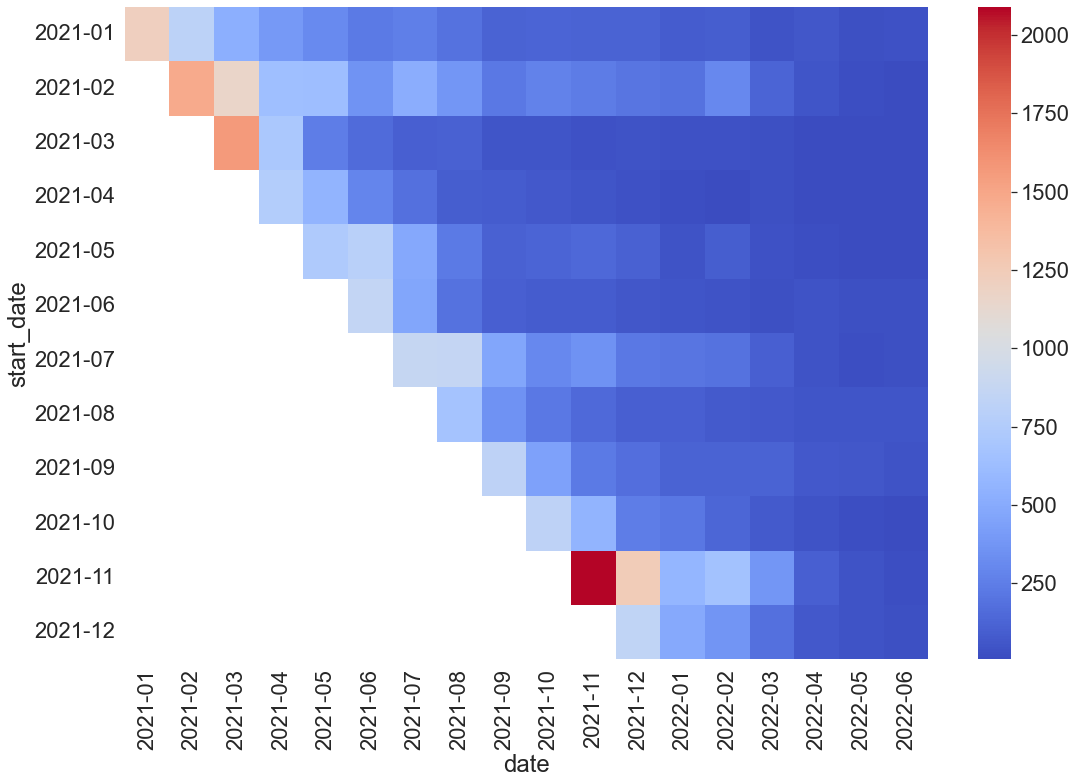

In [267]:
sns.set(font_scale=2,style="whitegrid",rc={'figure.figsize':(18,12)})
sns.heatmap(retention_sessions, cmap = 'coolwarm')

In [ ]:
df3 = df2[df2['date'] > df2['start_date']]
df3

In [ ]:
df3

In [277]:
df3['date'] = df3['date'].astype('datetime64[D]')
df3['start_date'] = df3['start_date'].astype('datetime64[D]')

In [278]:
df3['maturity_days'] = ((df3['date'] - df3['start_date'])/np.timedelta64(1, 'D')).round().astype(int)


In [ ]:
df3['maturity_month'] = ((df3['date'] - df3['start_date'])/np.timedelta64(1, 'M')).round().astype(int)
df3.reset_index()

Text(0, 0.5, 'Кол-во сессий')

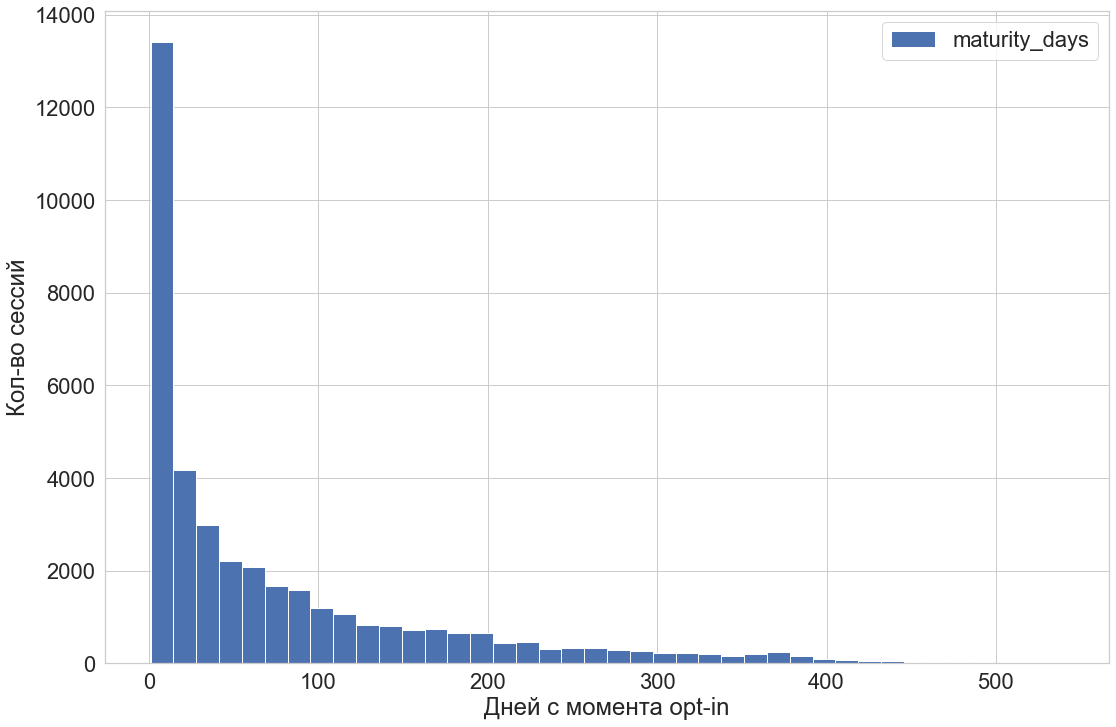

In [280]:
axarr = df3['maturity_days'].hist(bins=40, legend = True)
axarr.set_xlabel("Дней с момента opt-in")
axarr.set_ylabel("Кол-во сессий")

In [281]:
df3 = df3.reset_index()

In [282]:
df4 = df3.groupby(['maturity_days'],as_index=False,)['visitId'].count()

In [283]:
df4['share'] = df4['visitId'] / 38935 * 100

In [ ]:
df3.reset_index()

df3['start_month'] = df3['start_date'].astype('datetime64[M]').dt.strftime('%Y-%m')
retention_lifetime = df3.reset_index().pivot_table(index='start_month',columns='maturity_month',values='fullVisitorId', aggfunc='count')

df3

<AxesSubplot:xlabel='maturity_month', ylabel='start_month'>

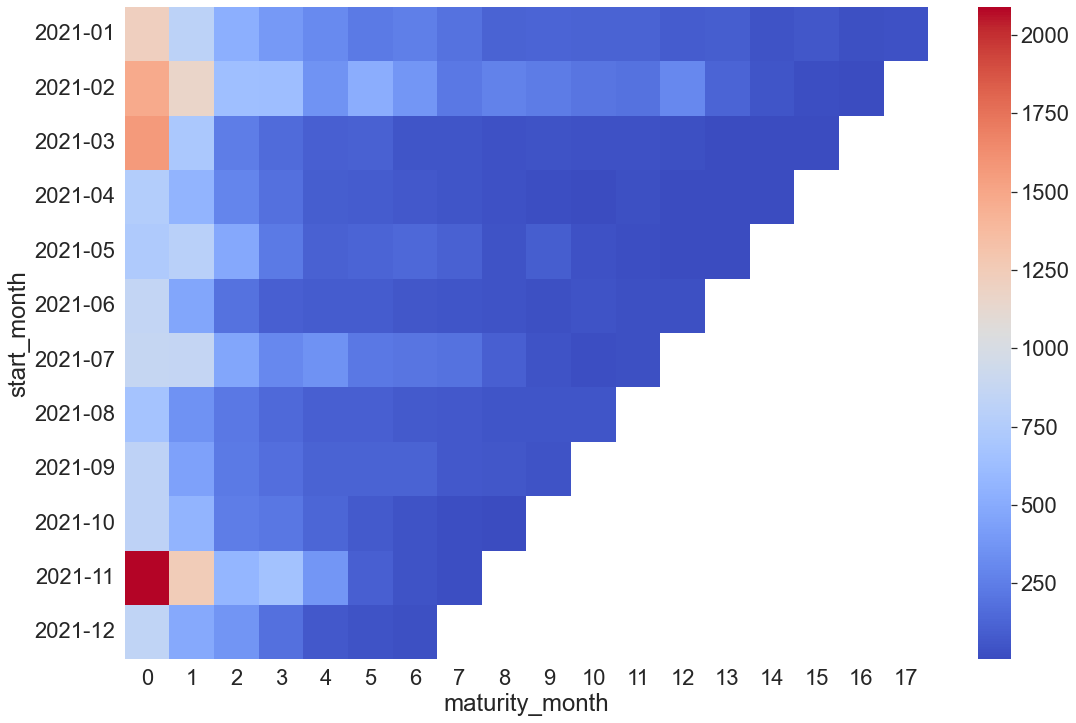

In [256]:
sns.set(font_scale=2,style="whitegrid",rc={'figure.figsize':(18,12)})
sns.heatmap(retention_lifetime, cmap = 'coolwarm')

In [257]:
retention_lifetime.to_csv("retention_lifetime.csv")